In [200]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("data/car_prediction_data.csv")

# Revisar info básica
df.head()
df.info()

# 🔹 Conversión de precios a euros
INR_TO_EUR = 0.011
LAKH_TO_INR = 100000

df["Selling_Price_EUR"] = df["Selling_Price"] * LAKH_TO_INR * INR_TO_EUR
df["Present_Price_EUR"] = df["Present_Price"] * LAKH_TO_INR * INR_TO_EUR

# Verificamos la conversión
df[["Selling_Price", "Selling_Price_EUR", "Present_Price", "Present_Price_EUR"]].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,Selling_Price,Selling_Price_EUR,Present_Price,Present_Price_EUR
0,3.35,3685.0,5.59,6149.0
1,4.75,5225.0,9.54,10494.0
2,7.25,7975.0,9.85,10835.0
3,2.85,3135.0,4.15,4565.0
4,4.60,5060.0,6.87,7557.0


## 🔎 Exploración inicial
Veamos cuántas filas y columnas tenemos, y qué variables incluye el dataset.

In [201]:
# Dimensión del dataset
print("Shape (filas, columnas):", df.shape)

# Lista de columnas
print("\nColumnas:")
print(df.columns.tolist())

# Info general: tipos de datos y nulos
print("\nInfo del DataFrame:")
print(df.info())

Shape (filas, columnas): (301, 11)

Columnas:
['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Selling_Price_EUR', 'Present_Price_EUR']

Info del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Car_Name           301 non-null    object 
 1   Year               301 non-null    int64  
 2   Selling_Price      301 non-null    float64
 3   Present_Price      301 non-null    float64
 4   Kms_Driven         301 non-null    int64  
 5   Fuel_Type          301 non-null    object 
 6   Seller_Type        301 non-null    object 
 7   Transmission       301 non-null    object 
 8   Owner              301 non-null    int64  
 9   Selling_Price_EUR  301 non-null    float64
 10  Present_Price_EUR  301 non-null    float64
dtypes: float64(4), int64(3), object(4)


## 🧹 Valores nulos y categorías
Ahora comprobamos si el dataset tiene valores nulos y cuántos valores únicos hay por columna.

In [202]:
# Nulos por columna
print("\nNulos por columna:")
print(df.isnull().sum())

# Número de valores únicos por columna
print("\nValores únicos por columna:")
print(df.nunique())


Nulos por columna:
Car_Name             0
Year                 0
Selling_Price        0
Present_Price        0
Kms_Driven           0
Fuel_Type            0
Seller_Type          0
Transmission         0
Owner                0
Selling_Price_EUR    0
Present_Price_EUR    0
dtype: int64

Valores únicos por columna:
Car_Name              98
Year                  16
Selling_Price        156
Present_Price        147
Kms_Driven           206
Fuel_Type              3
Seller_Type            2
Transmission           2
Owner                  3
Selling_Price_EUR    156
Present_Price_EUR    147
dtype: int64


## ✅ Conclusiones de la exploración

- Filas y columnas: **301 filas, 9 columnas**  
- Columna objetivo (target): **Selling_Price**  
- Variables numéricas: `Year`, `Present_Price`, `Kms_Driven`, `Owner`  
- Variables categóricas: `Car_Name`, `Fuel_Type`, `Seller_Type`, `Transmission`  
- No hay valores nulos → no necesitamos limpieza en este paso  
- Observación: `Car_Name` tiene muchas categorías (98), quizá no sea útil como variable directamente  

# 🧹 Preparación de datos
- Variable objetivo (`y`): Selling_Price  
- Features (`X`): Year, Present_Price, Kms_Driven, Owner, Fuel_Type, Seller_Type, Transmission  
- Se descarta: Car_Name

In [203]:
# Variable objetivo
y = df['Selling_Price_EUR']

# Features: todas menos Selling_Price y Car_Name
X = df.drop(columns=['Selling_Price', 'Selling_Price_EUR', 'Car_Name'], axis=1)

X.head()

,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Present_Price_EUR
0,2014,5.59,27000,Petrol,Dealer,Manual,0,6149.0
1,2013,9.54,43000,Diesel,Dealer,Manual,0,10494.0
2,2017,9.85,6900,Petrol,Dealer,Manual,0,10835.0
3,2011,4.15,5200,Petrol,Dealer,Manual,0,4565.0
4,2014,6.87,42450,Diesel,Dealer,Manual,0,7557.0


## 🔠 Conversión de variables categóricas (OneHotEncoding)

Los modelos de Machine Learning solo trabajan con **números**, no entienden texto.  
En nuestro dataset tenemos varias columnas categóricas:  

- `Fuel_Type` → valores como *Petrol*, *Diesel*, *CNG*  
- `Seller_Type` → valores como *Dealer*, *Individual*  
- `Transmission` → valores como *Manual*, *Automatic*  

Para poder usarlas en el modelo, aplicamos **OneHotEncoding**, que transforma cada categoría en una columna binaria (0 o 1).  

Ejemplo con `Fuel_Type`:  
- Petrol → (0,1)  
- Diesel → (1,0)  

Usaremos `pd.get_dummies()` de pandas con `drop_first=True` para evitar columnas redundantes.

In [204]:
# Aplicar OneHotEncoding a las columnas categóricas
X = pd.get_dummies(X, drop_first=True)

# Verificamos cómo quedó el dataset
X.head()

,Year,Present_Price,Kms_Driven,Owner,Present_Price_EUR,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,2014,5.59,27000,0,6149.0,False,True,False,True
1,2013,9.54,43000,0,10494.0,True,False,False,True
2,2017,9.85,6900,0,10835.0,False,True,False,True
3,2011,4.15,5200,0,4565.0,False,True,False,True
4,2014,6.87,42450,0,7557.0,True,False,False,True


## ✂️ División en Train/Test
Antes de entrenar, dividimos los datos en dos conjuntos:
- **Train (80%)** → usado para entrenar el modelo.
- **Test (20%)** → usado para evaluar la capacidad de generalización del modelo.

In [205]:
from sklearn.model_selection import train_test_split

# División de los datos (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((240, 9), (61, 9))

## 📈 Primer Modelo: Linear Regression
Entrenamos un modelo de regresión lineal usando Scikit-learn:
1. Creamos el modelo.
2. Lo entrenamos con los datos de entrenamiento (`X_train`, `y_train`).
3. Hacemos predicciones sobre los datos de test (`X_test`).

In [206]:
from sklearn.linear_model import LinearRegression

# 1. Crear el modelo
lin_model = LinearRegression()

# 2. Entrenar con los datos de entrenamiento
lin_model.fit(X_train, y_train)

# 3. Predecir sobre los datos de test
y_pred = lin_model.predict(X_test)

# Mostramos las primeras predicciones
y_pred[:10]

# Comparar primeros 10 precios reales vs predichos
comparison = pd.DataFrame({
    "Real (€)": y_test[:10].values,
    "Predicho (€)": y_pred[:10]
})

comparison


,Real (€),Predicho (€)
0,385.0,3250.877338
1,11121.0,8996.832903
2,5445.0,7099.699826
3,165.0,-1566.592515
4,7645.0,9997.789055
5,8195.0,8160.079846
6,1210.0,1470.087136
7,550.0,924.299382
8,495.0,1501.521442
9,6600.0,8239.294861


## 🌲 Random Forest Regressor
Probamos un modelo de Random Forest, que suele funcionar mejor que la regresión lineal porque captura relaciones no lineales.

In [207]:
from sklearn.ensemble import RandomForestRegressor

# 1. Crear el modelo
rf_model = RandomForestRegressor(random_state=42)

# 2. Entrenar
rf_model.fit(X_train, y_train)

# 3. Predecir
y_pred_rf = rf_model.predict(X_test)

# Mostramos las primeras predicciones
y_pred_rf[:10]

comparison = pd.DataFrame({
    "Real (€)": y_test[:10].values,
    "Predicho (€)": y_pred_rf[:10]
})

comparison

,Real (€),Predicho (€)
0,385.0,485.98
1,11121.0,12061.28
2,5445.0,5381.75
3,165.0,223.63
4,7645.0,8503.33
5,8195.0,6815.60
6,1210.0,1229.69
7,550.0,645.15
8,495.0,510.84
9,6600.0,7610.35


## 🚀 Gradient Boosting Regressor
Probamos un modelo de Gradient Boosting, que construye árboles de forma secuencial corrigiendo los errores de los anteriores.

In [208]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Crear el modelo
gb_model = GradientBoostingRegressor(random_state=42)

# 2. Entrenar
gb_model.fit(X_train, y_train)

# 3. Predecir
y_pred_gb = gb_model.predict(X_test)

# Mostramos las primeras predicciones
y_pred_gb[:10]

comparison = pd.DataFrame({
    "Real (€)": y_test[:10].values,
    "Predicho (€)": y_pred_gb[:10]
})

comparison


,Real (€),Predicho (€)
0,385.0,618.172831
1,11121.0,11594.115373
2,5445.0,5152.019799
3,165.0,310.332861
4,7645.0,8795.958015
5,8195.0,7411.885777
6,1210.0,1199.256001
7,550.0,678.638109
8,495.0,538.317285
9,6600.0,7416.653397


## 📊 Evaluación de Modelos

Ya hemos entrenado 3 modelos diferentes:  
- **Linear Regression**  
- **Random Forest Regressor**  
- **Gradient Boosting Regressor**

Ahora vamos a evaluarlos con las métricas más comunes en problemas de regresión:

- **MAE (Mean Absolute Error):** error medio absoluto entre predicciones y valores reales.  
- **RMSE (Root Mean Squared Error):** error cuadrático medio, más sensible a errores grandes.  
- **R² (Coeficiente de determinación):** mide qué tan bien se ajusta el modelo (1 = perfecto, 0 = malo).

De esta forma podremos comparar cuál modelo predice mejor el precio de los coches.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Función auxiliar para calcular métricas
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # aquí hacemos la raíz cuadrada
    r2 = r2_score(y_true, y_pred)
    return pd.Series({
        "MAE (€)": round(mae, 2),
        "RMSE (€)": round(rmse, 2),
        "R²": round(r2, 4)
    }, name=model_name)


# Comparar los tres modelos
results = pd.DataFrame([
    evaluate_model(y_test, y_pred, "Linear Regression"),
    evaluate_model(y_test, y_pred_rf, "Random Forest"),
    evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
])

results


,MAE (€),RMSE (€),R²
Linear Regression,1337.85,2051.67,0.8490
Random Forest,688.36,1018.04,0.9628
Gradient Boosting,615.97,922.26,0.9695


## 📊 Resultados de los Modelos

Hemos evaluado los tres modelos usando las métricas más comunes en regresión:

- **MAE (Mean Absolute Error):** error medio absoluto en euros. Cuanto más bajo, mejor.  
- **RMSE (Root Mean Squared Error):** error cuadrático medio, más sensible a errores grandes.  
- **R² (Coeficiente de determinación):** mide qué tan bien se ajusta el modelo a los datos (1 = ajuste perfecto).

### 📌 Comparación
- **Linear Regression**: peor rendimiento, con errores altos.  
- **Random Forest**: mejora mucho respecto a la regresión lineal.  
- **Gradient Boosting**: mejor modelo, con el menor error y el mayor R² (casi 97%). 🎯

## 🎨 Visualización: Valores Reales vs Predichos

Además de las métricas, vamos a visualizar cómo se comparan las predicciones frente a los valores reales.

La idea es representar:
- En el eje X: valores reales (€).  
- En el eje Y: valores predichos (€).  
- Una línea diagonal que representaría el ajuste perfecto (Real = Predicho).

👉 Si los puntos están cerca de la diagonal, significa que el modelo predice bien.

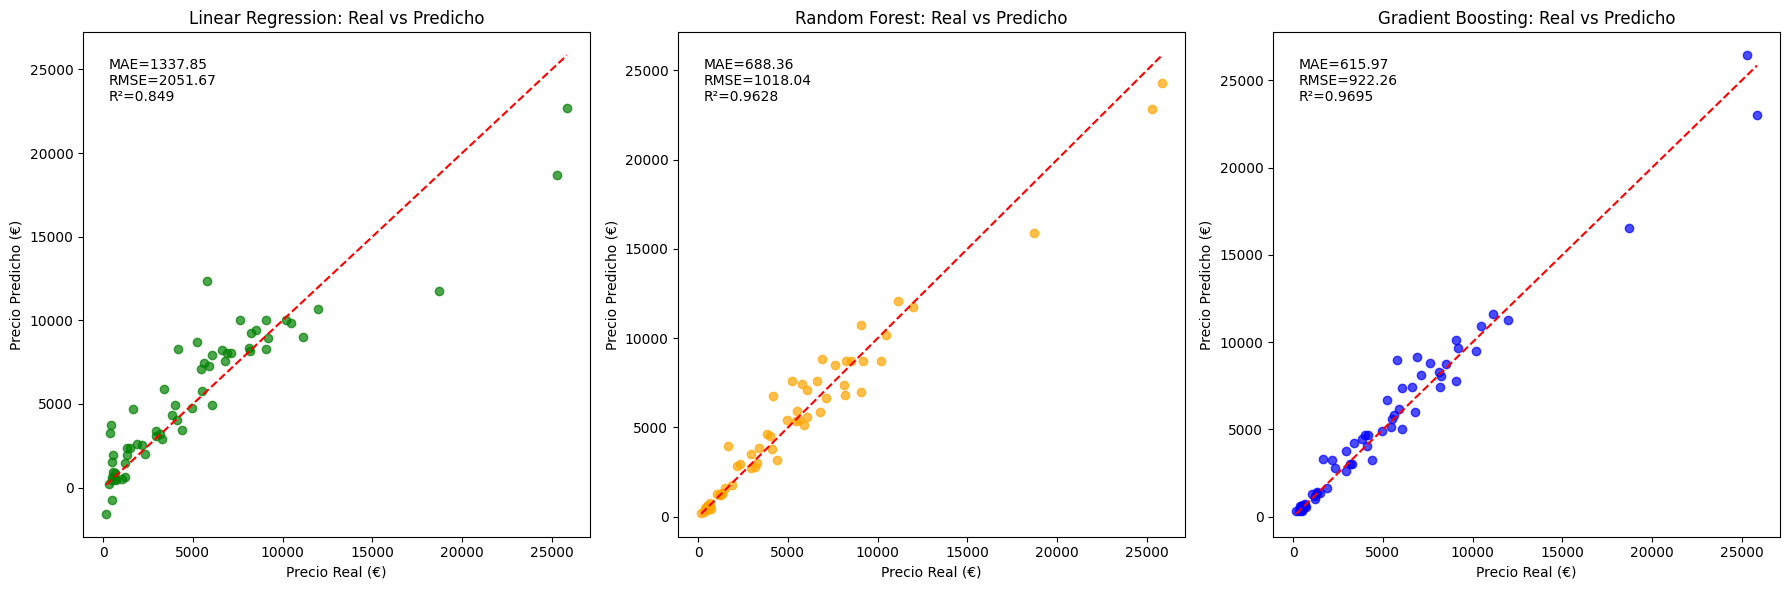

In [ ]:
import matplotlib.pyplot as plt

# Métricas ya calculadas (puedes cambiarlas si tienes resultados distintos)
metrics = {
    "Linear Regression": {"MAE": 1337.85, "RMSE": 2051.67, "R²": 0.8490},
    "Random Forest": {"MAE": 688.36, "RMSE": 1018.04, "R²": 0.9628},
    "Gradient Boosting": {"MAE": 615.97, "RMSE": 922.26, "R²": 0.9695}
}

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# --- Linear Regression ---
axes[0].scatter(y_test, y_pred, alpha=0.7, color="green")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color="red", linestyle="--")
axes[0].set_title("Linear Regression: Real vs Predicho")
axes[0].set_xlabel("Precio Real (€)")
axes[0].set_ylabel("Precio Predicho (€)")
axes[0].text(0.05, 0.95, 
             f"MAE={metrics['Linear Regression']['MAE']}\nRMSE={metrics['Linear Regression']['RMSE']}\nR²={metrics['Linear Regression']['R²']}", 
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

# --- Random Forest ---
axes[1].scatter(y_test, y_pred_rf, alpha=0.7, color="orange")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color="red", linestyle="--")
axes[1].set_title("Random Forest: Real vs Predicho")
axes[1].set_xlabel("Precio Real (€)")
axes[1].set_ylabel("Precio Predicho (€)")
axes[1].text(0.05, 0.95, 
             f"MAE={metrics['Random Forest']['MAE']}\nRMSE={metrics['Random Forest']['RMSE']}\nR²={metrics['Random Forest']['R²']}", 
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top')

# --- Gradient Boosting ---
axes[2].scatter(y_test, y_pred_gb, alpha=0.7, color="blue")
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color="red", linestyle="--")
axes[2].set_title("Gradient Boosting: Real vs Predicho")
axes[2].set_xlabel("Precio Real (€)")
axes[2].set_ylabel("Precio Predicho (€)")
axes[2].text(0.05, 0.95, 
             f"MAE={metrics['Gradient Boosting']['MAE']}\nRMSE={metrics['Gradient Boosting']['RMSE']}\nR²={metrics['Gradient Boosting']['R²']}", 
             transform=axes[2].transAxes, fontsize=10, verticalalignment='top')

# Ajustar espaciado
plt.tight_layout()
plt.show()


## 📊 Conclusiones

Tras entrenar y evaluar tres modelos distintos para predecir el precio de coches de segunda mano, obtenemos las siguientes observaciones:

1. **Linear Regression**

   * Es un modelo simple y rápido, pero sus predicciones presentan bastante dispersión.
   * Métricas: MAE ≈ 1337 €, RMSE ≈ 2052 €, R² ≈ 0.849.
   * No captura bien las relaciones no lineales.

2. **Random Forest**

   * Modelo mucho más robusto.
   * Reduce notablemente los errores: MAE ≈ 688 €, RMSE ≈ 1018 €, R² ≈ 0.963.
   * Se adapta mejor a la complejidad de los datos.

3. **Gradient Boosting**

   * Es el modelo con mejor rendimiento.
   * Métricas: MAE ≈ 616 €, RMSE ≈ 922 €, R² ≈ 0.970.
   * Las gráficas muestran que sus predicciones están muy cerca de la línea ideal.

---

✅ **Conclusión final:**
Para este dataset, el modelo de **Gradient Boosting** es el más preciso y confiable para predecir precios de coches usados.
Random Forest también ofrece un rendimiento excelente, mientras que Linear Regression se queda corto en comparación.

En un escenario real, se recomendaría usar **Gradient Boosting** como modelo principal para desplegar una aplicación de predicción de precios.
